In [1]:
# calculate elapsed time
import time
start_time = time.time()

#### IMPORT

In [2]:
import os, platform
import py7zr

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical 
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, \
    BatchNormalization, Flatten, LSTM
# from scikeras.wrappers import KerasClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc

from itertools import cycle
from scipy import interp
from scipy.optimize import brentq
from scipy.interpolate import interp1d

#### PARAMETERS
- Set the condition
> * N_FEATURES: Number of Features
> * CHECK_BLANKS: Check for blank data. If any blank data is found, the whole row of data will be deleted.
> * CHECK_CLASS_IMBALANCE: Check for dataset class imbalance. The more balance the dataset, the less biases the model will be.

In [3]:
##############################
# # deep learning features # #
##############################
SEED = 1005 # random seed for reproducibility

# should make this dynamic
N_FEATURES = 220
TIMESTEPS = 1
EPOCH=400
BATCH_SIZE=200

SPLIT_RATIO=0.2

###############
# # preview # #
###############
f = False
t = True

# checking dataset
CHECK_BLANKS = True
CHECK_CLASS_IMBALANCE = True

# evaluate suitable kfold number and kfold model
MIN_KFOLD = 2
MAX_KFOLD = 11
N_KFOLD = 5
EVAL_KFOLD_NUM = False
EVAL_KFOLD_MODEL = False
PERFORM_KFOLD = True

# model testing
TEST_MODEL = True
CON_MATRIX = True
ROC_GRAPH = True

###############
# # dataset # #
###############
CLASSES_COL_NAME = "Subject"
CLASSES_COL_NUM = 0
FEATURES_COL_NUM = 2

DATASET_DIR_NAME = "dataset\set04\\11_same"
SAMPLE_DATASET_NAME = "same_train"
ACTUAL_DATASET_NAME = "same_test"

MODEL_DIR_NAME = "dataset\set04\\11_same"
MODEL_NAME = "model_" + "set04_11_same"

RESULT_DIR_NAME = "dataset\set04\\11_same"
RESULT_NAME = "result_" + "set04_11_same"

DATASET_DIR_PATH = os.path.join(os.getcwd(), DATASET_DIR_NAME)
SAMPLE_DATASET_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME + ".csv")
ACTUAL_DATASET_PATH = os.path.join(DATASET_DIR_PATH, ACTUAL_DATASET_NAME + ".csv")

MODEL_DIR_PATH = os.path.join(os.getcwd(), MODEL_DIR_NAME)
MODEL_PATH = os.path.join(MODEL_DIR_PATH, MODEL_NAME + ".h5")

RESULT_DIR_PATH = os.path.join(os.getcwd(), RESULT_DIR_NAME)
RESULT_PATH = os.path.join(RESULT_DIR_PATH, RESULT_NAME + ".csv")

#################
# # sns theme # #
#################
# sns.set_theme(style="darkgrid") # (dark background with white gridlines)
sns.set_theme(style="whitegrid") # (white background with grey gridlines)
# sns.set_theme(style="dark") # (dark background with no gridlines)
# sns.set_theme(style="white") # (white background with no gridlines)
# sns.set_theme(style="ticks") # (white background with axis ticks and no gridlines)

In [4]:
if os.path.isdir(DATASET_DIR_PATH) is True:
    print(f"Dataset directory exists at: {DATASET_DIR_PATH}")
else:
    try:
        os.mkdir(DATASET_DIR_PATH, 666)
        print(f"Dataset directory have been created at: {DATASET_DIR_PATH}")
    except:
        print("Error: Dataset Directory not created")
        
if os.path.isdir(MODEL_DIR_PATH) is True:
    print(f"Model directory exists at: {MODEL_DIR_PATH}")
else:
    try:
        os.mkdir(MODEL_DIR_PATH, 666)
        print(f"Model directory have been created at: {MODEL_DIR_PATH}")
    except:
        print("Error: Model Directory not created")
    
if os.path.exists(SAMPLE_DATASET_PATH) is True:
    print(f"Training dataset exists at: {SAMPLE_DATASET_PATH}")
else:
    try:
        SAMPLE_7Z_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME + ".7z")
        with py7zr.SevenZipFile(SAMPLE_7Z_PATH, mode='r') as z:
            z.extractall(path=DATASET_DIR_PATH)
        print(f"Decompress 7z file to: {SAMPLE_7Z_PATH}")
    except:
        print("Error: Failed to decompress 7z file.")

Dataset directory exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set04\11_same
Model directory exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set04\11_same
Training dataset exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set04\11_same\same_train.csv


#### CREATE MODEL
- Create base model
- Wrap it with KerasClassifier

In [5]:
#create base model
def create_base_model():
    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True,
             input_shape=(TIMESTEPS,N_FEATURES)))
    model.add(Dense(256, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dense(128, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dense(64, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=32, return_sequences=True))
    model.add(Dense(32, activation='sigmoid'))
    model.add(Dropout(0.2))

    # softmax for multi-class classification
    model.add(Flatten())
    print("There are a total of " + str(n_classes) + " classes.")
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=['accuracy'])
    return model

# wrap model in KerasClassifier
def create_model():
    model = KerasClassifier(build_fn=create_base_model, epochs=EPOCH, 
                            batch_size=BATCH_SIZE)
    return model

In [6]:
# divide data into features X and target (classes) Y
def prepare_dataset(df):
    X = df.values[:,FEATURES_COL_NUM:].astype(float)
    Y = df.values[:,CLASSES_COL_NUM].astype(str)

    # convert target Y to labelbinarizer Y for model
    # fit_transform is not used to reuse lb
    Y = Y.reshape(-1, 1)
    lb = LabelBinarizer().fit(Y)
    Y = lb.transform(Y)

    #################################
    # # get all the encoded class # #
    #################################
    print("LabelBinarizer is able to decipher: ")
    print(lb.classes_)
    print("\n")

    ###########################
    # # print X and Y shape # #
    ###########################
    print(f"X | Features | Dataset Shape: {X.shape}")
    print(f"Y | Classes  | Dataset Shape: {Y.shape}")

    return X, Y, lb, lb.classes_.tolist()

In [7]:
def split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED):

    ##############################################################
    # # split dataset into train and test set of 0.8/0.2 ratio # #
    ##############################################################
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=SPLIT_RATIO, random_state=SEED)

    ############################
    # # reshaping of dataset # #
    ############################

    # reshaping the dataset to include LSTM Timesteps
    print(X_train.dtype)
    X_train = np.asarray(X_train, dtype=np.float32)
    print(X_train.dtype)
    X_train = np.reshape(X_train, (X_train.shape[0], TIMESTEPS, X_train.shape[1]))
    print(X_test.dtype)
    X_test = np.asarray(X_test, dtype=np.float32)
    print(X_test.dtype)
    X_test = np.reshape(X_test, (X_test.shape[0], TIMESTEPS, X_test.shape[1]))

    print(f"X train shape: {X_train.shape}")
    print(f"Y train shape: {y_train.shape}")
    print(f"X test shape: {X_test.shape}")
    print(f"Y test shape: {y_test.shape}")
    
    return X_train, X_test, y_train, y_test

def reshape_dataset(X, TIMESTEPS):
    # reshaping the dataset to include LSTM Timesteps
    X = np.asarray(X, dtype=np.float32)
    X = np.reshape(X, (X.shape[0], TIMESTEPS, X.shape[1]))
    return X

#### LOAD DATASET

In [8]:
# load dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)
df.head()

,Subject,Password,T2-D|0,T2-I|0+1,T2-PF|0+1,T2-RF|0+1,T2-NG|0+1,T2-D|1,T2-I|1+2,T2-PF|1+2,...,T7-RF|VAR,T7-NG|VAR,T7-I|SD,T7-PF|SD,T7-RF|SD,T7-NG|SD,T8-I|0+7,T8-PF|0+7,T8-RF|0+7,T8-NG|0+7
0,andy,dEcisi0n,0.078293,0.123274,0.201567,0.235551,0.313844,0.112277,0.067947,0.180224,...,0.014072,0.008948,0.126700,0.102669,0.118626,0.094595,0.889900,0.968193,0.989548,1.067841
1,andy,dEcisi0n,0.089872,0.135437,0.225308,0.203912,0.293784,0.068475,0.088657,0.157132,...,0.011081,0.014495,0.065051,0.080180,0.105265,0.120395,0.856497,0.946369,0.933958,1.023829
2,andy,dEcisi0n,0.100823,0.100237,0.201061,0.201381,0.302204,0.101144,0.044354,0.145498,...,0.012190,0.012140,0.086086,0.085859,0.110409,0.110182,0.742216,0.843040,0.808707,0.909530
3,andy,dEcisi0n,0.090142,0.112780,0.202921,0.192025,0.282167,0.079245,0.111987,0.191232,...,0.009144,0.010677,0.080989,0.088693,0.095626,0.103331,0.833344,0.923486,0.900271,0.990412
4,andy,dEcisi0n,0.077035,0.124322,0.201357,0.213968,0.291003,0.089646,0.057870,0.147516,...,0.009157,0.007530,0.120318,0.111400,0.095693,0.086775,0.743791,0.820826,0.833329,0.910364


#### CHECK DATASET

Checking for blanks...
No blank value has been found.
Checking for class imbalance...


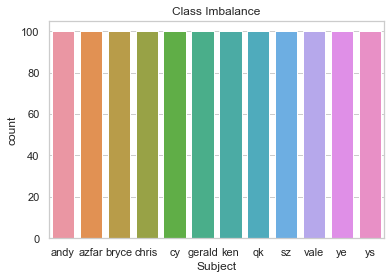

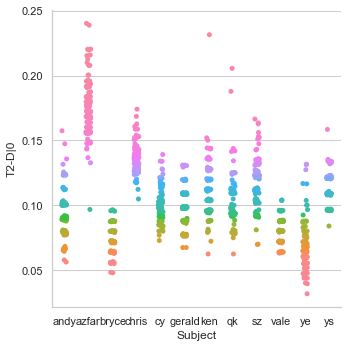

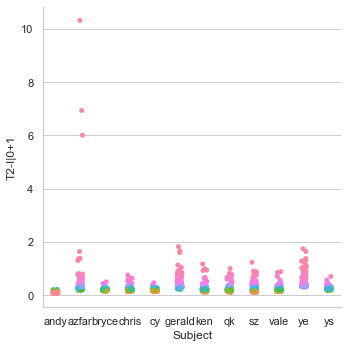

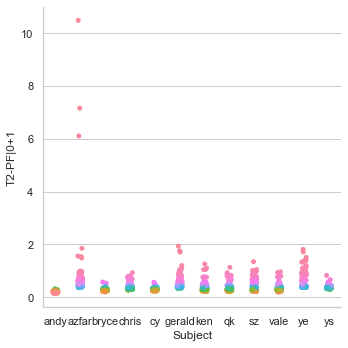

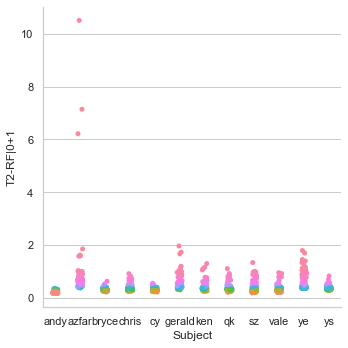

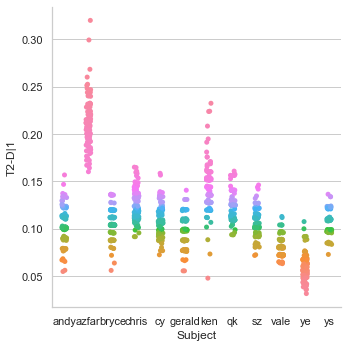

In [9]:
########################
# # check for blanks # #
########################
if CHECK_BLANKS is True:
    # checking for blanks
    print("Checking for blanks...")
    if df.isnull().values.any() is True:
        df = df.dropna(axis=0, how="any")
        print("Blank rows has been dropped.")
    else:
        print("No blank value has been found.")
        
#################################
# # check for class imbalance # #
#################################
if CHECK_CLASS_IMBALANCE is True:
    print("Checking for class imbalance...")
    sns.countplot(x=CLASSES_COL_NAME, data=df).set_title("Class Imbalance")
#     df.loc[(df!=0).any(axis=1)]
    plt.show()

sns.catplot(x="Subject", y="T2-D|0", hue="T2-D|0", data=df, legend=False)
sns.catplot(x="Subject", y="T2-I|0+1", hue="T2-I|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-PF|0+1", hue="T2-PF|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-RF|0+1", hue="T2-RF|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-D|1", hue="T2-D|1", data=df, legend=False)

#### PREPARE DATASET
- Split data based on X / Features and Y / Classes
- Binarize Y into binary labels

In [10]:
X, Y, lb, class_list = prepare_dataset(df)
n_classes = len(class_list)
print(f"Number of Classes: {n_classes}")

LabelBinarizer is able to decipher: 
['andy' 'azfar' 'bryce' 'chris' 'cy' 'gerald' 'ken' 'qk' 'sz' 'vale' 'ye'
 'ys']


X | Features | Dataset Shape: (1200, 220)
Y | Classes  | Dataset Shape: (1200, 12)
Number of Classes: 12


#### SPLIT DATASET
- Split dataset into train set and test set 0.8 / 0.2

In [11]:
##############################################################
# # split dataset into train and test set of 0.8/0.2 ratio # #
##############################################################
X_train, X_test, y_train, y_test = split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED)

float64
float32
float64
float32
X train shape: (960, 1, 220)
Y train shape: (960, 12)
X test shape: (240, 1, 220)
Y test shape: (240, 12)


#### PERFORM VALIDATION (w KFold Validation)
- Evaluate best KFold Validation
- Generate loss and accuracy graph
- Perform KFold validation

##### Evaluate suitable folds for kfold validation

In [12]:
###############################################
# # evaluate suitable kfold value for model # #
###############################################
def evaluate_kfold(X_train, y_train, SEED, MIN_KFOLD, MAX_KFOLD):
    
    # evaluate the model    
    folds = range(MIN_KFOLD, MAX_KFOLD)
    means, mins, maxs = list(), list(), list()
    
    # evaluate each k value
    for k in folds:
        # define the test condition
        kfold = KFold(n_splits=k, shuffle=True, random_state=SEED)
        
        # evaluate k value
        model = create_model()
        scores = cross_val_score(model, X_train, y_train, cv=kfold, n_jobs=-1)
        
        k_mean = np.mean(scores)
        k_min = scores.min()
        k_max = scores.max()
        
        # report performance
        print(f"No. of Folds: {k} | Accuracy: {k_mean*100:.3f} | Min: {k_min*100:.3f} | Max: {k_max*100:.3f}")
        
        # store mean accuracy and min and max relative to the mean
        means.append(k_mean)
        mins.append(k_mean - k_min)
        maxs.append(k_max - k_mean)
        
    # line plot of k mean values with min/max error bars
    clear_output(wait=True)
    pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
    
    # show the plot
    pyplot.show()
    
if EVAL_KFOLD_NUM is True:
    evaluate_kfold(X_train, y_train, SEED, MIN_KFOLD, MAX_KFOLD)
else:
    print("EVAL_KFOLD_NUM is not True")

EVAL_KFOLD_NUM is not True


##### Generate kfold validation accuracy and loss

In [13]:
##################################################
# # evaluate kfold model for accuracy and loss # #
##################################################
def evaluate_kfold_model(X_train, y_train, SEED):
    scores, histories = list(), list()
    # create model
    model = create_model()
    # prepare cross validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
    # enumerate splits
    for train_ix, test_ix in kfold.split(X_train):
        # select rows for train and test
        trainX, trainY, testX, testY = X_train[train_ix], y_train[train_ix], X_train[test_ix], y_train[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=100, batch_size=50, validation_data=(testX, testY), verbose=0)
        
        # evaluate model
        y_pred = model.predict(testX)
        y_pred = to_categorical(y_pred)

        # evaluate predictions
        acc = accuracy_score(testY, y_pred)
        print("Testing accuracy: %.3f%%" % (acc*100))

        # stores scores and histories
        scores.append(acc)
        histories.append(history)

    for i in range(len(histories)):
        # plot loss
        f1 = plt.figure(1)
        plt.title('Categorical Cross-Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue')
        plt.plot(histories[i].history['val_loss'], color='orange')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')

        # plot accuracy
        f2 = plt.figure(2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue')
        plt.plot(histories[i].history['val_accuracy'], color='orange')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='lower right')

    # print summary
    print(f"Accuracy | Mean: {np.mean(scores)*100:.3f} | Std: {np.std(scores)*100:.3f} | Length/no.: {len(scores)}")
    # box and whisker plots of results
    f3 = plt.figure(3)
    plt.title('Box and Whisker Plot of Accuracy Scores')
    plt.ylabel('accuracy')
    plt.xlabel('model')
    plt.boxplot(scores)
    clear_output(wait=True)
    plt.show()
    
if EVAL_KFOLD_MODEL is True:
    evaluate_kfold_model(X_train, y_train, SEED)
else:
    print("EVAL_KFOLD_MODEL is not true")

EVAL_KFOLD_MODEL is not true


##### Perform Actual KFold validation

In [14]:
if PERFORM_KFOLD is True:
    # create model
    model = create_model()
    kfold = KFold(n_splits=N_KFOLD, shuffle=True, random_state=SEED)
    valid_score = cross_val_score(model, X_train, y_train, 
                          cv=kfold, error_score="raise", verbose=0)
else:
    print("PERFORM_KFOLD is not true.")

There are a total of 12 classes.
Epoch 1/400
4/4 [==============================] - 7s 22ms/step - loss: 2.8063 - accuracy: 0.0964
Epoch 2/400
4/4 [==============================] - 0s 18ms/step - loss: 2.7654 - accuracy: 0.0898
Epoch 3/400
4/4 [==============================] - 0s 19ms/step - loss: 2.7363 - accuracy: 0.0807
Epoch 4/400
4/4 [==============================] - 0s 19ms/step - loss: 2.7016 - accuracy: 0.0820
Epoch 5/400
4/4 [==============================] - 0s 19ms/step - loss: 2.6733 - accuracy: 0.0898
Epoch 6/400
4/4 [==============================] - 0s 20ms/step - loss: 2.6634 - accuracy: 0.0977
Epoch 7/400
4/4 [==============================] - 0s 20ms/step - loss: 2.6522 - accuracy: 0.0859
Epoch 8/400
4/4 [==============================] - 0s 21ms/step - loss: 2.6397 - accuracy: 0.0755
Epoch 9/400
4/4 [==============================] - 0s 21ms/step - loss: 2.6123 - accuracy: 0.0781
Epoch 10/400
4/4 [==============================] - 0s 20ms/step - loss: 2.5847 - acc

4/4 [==============================] - 0s 22ms/step - loss: 1.4847 - accuracy: 0.3659
Epoch 166/400
4/4 [==============================] - 0s 21ms/step - loss: 1.5076 - accuracy: 0.3190
Epoch 167/400
4/4 [==============================] - 0s 21ms/step - loss: 1.4908 - accuracy: 0.3451
Epoch 168/400
4/4 [==============================] - 0s 21ms/step - loss: 1.4743 - accuracy: 0.3503
Epoch 169/400
4/4 [==============================] - 0s 20ms/step - loss: 1.4544 - accuracy: 0.3568
Epoch 170/400
4/4 [==============================] - 0s 21ms/step - loss: 1.4540 - accuracy: 0.3542
Epoch 171/400
4/4 [==============================] - 0s 22ms/step - loss: 1.4490 - accuracy: 0.3880
Epoch 172/400
4/4 [==============================] - 0s 20ms/step - loss: 1.4433 - accuracy: 0.3828
Epoch 173/400
4/4 [==============================] - 0s 21ms/step - loss: 1.4489 - accuracy: 0.3828
Epoch 174/400
4/4 [==============================] - 0s 22ms/step - loss: 1.4349 - accuracy: 0.3711
Epoch 175/400


4/4 [==============================] - 0s 21ms/step - loss: 1.2812 - accuracy: 0.4115
Epoch 248/400
4/4 [==============================] - 0s 20ms/step - loss: 1.2705 - accuracy: 0.4466
Epoch 249/400
4/4 [==============================] - 0s 20ms/step - loss: 1.2724 - accuracy: 0.4466
Epoch 250/400
4/4 [==============================] - 0s 20ms/step - loss: 1.3295 - accuracy: 0.4154
Epoch 251/400
4/4 [==============================] - 0s 20ms/step - loss: 1.3238 - accuracy: 0.4427
Epoch 252/400
4/4 [==============================] - 0s 22ms/step - loss: 1.2982 - accuracy: 0.4440
Epoch 253/400
4/4 [==============================] - 0s 21ms/step - loss: 1.2638 - accuracy: 0.4661
Epoch 254/400
4/4 [==============================] - 0s 23ms/step - loss: 1.2693 - accuracy: 0.4310
Epoch 255/400
4/4 [==============================] - 0s 23ms/step - loss: 1.2668 - accuracy: 0.4492
Epoch 256/400
4/4 [==============================] - 0s 21ms/step - loss: 1.2659 - accuracy: 0.4701
Epoch 257/400


4/4 [==============================] - 0s 21ms/step - loss: 0.9807 - accuracy: 0.5443
Epoch 330/400
4/4 [==============================] - 0s 21ms/step - loss: 0.9867 - accuracy: 0.5677
Epoch 331/400
4/4 [==============================] - 0s 20ms/step - loss: 0.9930 - accuracy: 0.5612
Epoch 332/400
4/4 [==============================] - 0s 21ms/step - loss: 0.9902 - accuracy: 0.5690
Epoch 333/400
4/4 [==============================] - 0s 20ms/step - loss: 1.0028 - accuracy: 0.5638
Epoch 334/400
4/4 [==============================] - 0s 21ms/step - loss: 0.9765 - accuracy: 0.5534
Epoch 335/400
4/4 [==============================] - 0s 21ms/step - loss: 0.9750 - accuracy: 0.5794
Epoch 336/400
4/4 [==============================] - 0s 21ms/step - loss: 0.9581 - accuracy: 0.5859
Epoch 337/400
4/4 [==============================] - 0s 20ms/step - loss: 0.9692 - accuracy: 0.5612
Epoch 338/400
4/4 [==============================] - 0s 21ms/step - loss: 0.9698 - accuracy: 0.5625
Epoch 339/400


4/4 [==============================] - 0s 23ms/step - loss: 2.5034 - accuracy: 0.0951
Epoch 11/400
4/4 [==============================] - 0s 23ms/step - loss: 2.5196 - accuracy: 0.0781
Epoch 12/400
4/4 [==============================] - 0s 22ms/step - loss: 2.5105 - accuracy: 0.0833
Epoch 13/400
4/4 [==============================] - 0s 22ms/step - loss: 2.4891 - accuracy: 0.1016
Epoch 14/400
4/4 [==============================] - 0s 23ms/step - loss: 2.4744 - accuracy: 0.1185
Epoch 15/400
4/4 [==============================] - 0s 22ms/step - loss: 2.4858 - accuracy: 0.1042
Epoch 16/400
4/4 [==============================] - 0s 23ms/step - loss: 2.4616 - accuracy: 0.1289
Epoch 17/400
4/4 [==============================] - 0s 22ms/step - loss: 2.4685 - accuracy: 0.1172
Epoch 18/400
4/4 [==============================] - 0s 22ms/step - loss: 2.4168 - accuracy: 0.1315
Epoch 19/400
4/4 [==============================] - 0s 23ms/step - loss: 2.4148 - accuracy: 0.1432
Epoch 20/400
4/4 [=====

4/4 [==============================] - 0s 21ms/step - loss: 1.3771 - accuracy: 0.4089
Epoch 175/400
4/4 [==============================] - 0s 22ms/step - loss: 1.3460 - accuracy: 0.4258
Epoch 176/400
4/4 [==============================] - 0s 23ms/step - loss: 1.3455 - accuracy: 0.4427
Epoch 177/400
4/4 [==============================] - 0s 23ms/step - loss: 1.3612 - accuracy: 0.4141
Epoch 178/400
4/4 [==============================] - 0s 22ms/step - loss: 1.3411 - accuracy: 0.4427
Epoch 179/400
4/4 [==============================] - 0s 22ms/step - loss: 1.3590 - accuracy: 0.4167
Epoch 180/400
4/4 [==============================] - 0s 23ms/step - loss: 1.3621 - accuracy: 0.4297
Epoch 181/400
4/4 [==============================] - 0s 24ms/step - loss: 1.3355 - accuracy: 0.3932
Epoch 182/400
4/4 [==============================] - 0s 23ms/step - loss: 1.2880 - accuracy: 0.4792
Epoch 183/400
4/4 [==============================] - 0s 23ms/step - loss: 1.2740 - accuracy: 0.4753
Epoch 184/400


4/4 [==============================] - 0s 22ms/step - loss: 0.9696 - accuracy: 0.5885
Epoch 257/400
4/4 [==============================] - 0s 23ms/step - loss: 1.0087 - accuracy: 0.5781
Epoch 258/400
4/4 [==============================] - 0s 22ms/step - loss: 0.9724 - accuracy: 0.5768
Epoch 259/400
4/4 [==============================] - 0s 22ms/step - loss: 0.9739 - accuracy: 0.6042
Epoch 260/400
4/4 [==============================] - 0s 22ms/step - loss: 0.9334 - accuracy: 0.6172
Epoch 261/400
4/4 [==============================] - 0s 22ms/step - loss: 0.9464 - accuracy: 0.5807
Epoch 262/400
4/4 [==============================] - 0s 24ms/step - loss: 0.9173 - accuracy: 0.5951
Epoch 263/400
4/4 [==============================] - 0s 23ms/step - loss: 0.8999 - accuracy: 0.5885
Epoch 264/400
4/4 [==============================] - 0s 24ms/step - loss: 0.9334 - accuracy: 0.5990
Epoch 265/400
4/4 [==============================] - 0s 24ms/step - loss: 0.9427 - accuracy: 0.5807
Epoch 266/400


4/4 [==============================] - 0s 22ms/step - loss: 0.8220 - accuracy: 0.6615
Epoch 339/400
4/4 [==============================] - 0s 22ms/step - loss: 0.7840 - accuracy: 0.6562
Epoch 340/400
4/4 [==============================] - 0s 22ms/step - loss: 0.8068 - accuracy: 0.6367
Epoch 341/400
4/4 [==============================] - 0s 22ms/step - loss: 0.8546 - accuracy: 0.6341
Epoch 342/400
4/4 [==============================] - 0s 22ms/step - loss: 0.8538 - accuracy: 0.6393
Epoch 343/400
4/4 [==============================] - 0s 22ms/step - loss: 0.8011 - accuracy: 0.6680
Epoch 344/400
4/4 [==============================] - 0s 22ms/step - loss: 0.7765 - accuracy: 0.6680
Epoch 345/400
4/4 [==============================] - 0s 22ms/step - loss: 0.7545 - accuracy: 0.6562
Epoch 346/400
4/4 [==============================] - 0s 22ms/step - loss: 0.7790 - accuracy: 0.6745
Epoch 347/400
4/4 [==============================] - 0s 22ms/step - loss: 0.7572 - accuracy: 0.6758
Epoch 348/400


4/4 [==============================] - 0s 24ms/step - loss: 1.7663 - accuracy: 0.2591
Epoch 102/400
4/4 [==============================] - 0s 23ms/step - loss: 1.7586 - accuracy: 0.2656
Epoch 103/400
4/4 [==============================] - 0s 23ms/step - loss: 1.7501 - accuracy: 0.2878
Epoch 104/400
4/4 [==============================] - 0s 23ms/step - loss: 1.7489 - accuracy: 0.2487
Epoch 105/400
4/4 [==============================] - 0s 23ms/step - loss: 1.7472 - accuracy: 0.2669
Epoch 106/400
4/4 [==============================] - 0s 23ms/step - loss: 1.7144 - accuracy: 0.2760
Epoch 107/400
4/4 [==============================] - 0s 23ms/step - loss: 1.6960 - accuracy: 0.2695
Epoch 108/400
4/4 [==============================] - 0s 22ms/step - loss: 1.7178 - accuracy: 0.2630
Epoch 109/400
4/4 [==============================] - 0s 24ms/step - loss: 1.7457 - accuracy: 0.2656
Epoch 110/400
4/4 [==============================] - 0s 24ms/step - loss: 1.6999 - accuracy: 0.2734
Epoch 111/400


4/4 [==============================] - 0s 22ms/step - loss: 1.3557 - accuracy: 0.4844
Epoch 184/400
4/4 [==============================] - 0s 22ms/step - loss: 1.3482 - accuracy: 0.4648
Epoch 185/400
4/4 [==============================] - 0s 25ms/step - loss: 1.3459 - accuracy: 0.4948
Epoch 186/400
4/4 [==============================] - 0s 24ms/step - loss: 1.3399 - accuracy: 0.5208
Epoch 187/400
4/4 [==============================] - 0s 24ms/step - loss: 1.3165 - accuracy: 0.5026
Epoch 188/400
4/4 [==============================] - 0s 23ms/step - loss: 1.3246 - accuracy: 0.5104
Epoch 189/400
4/4 [==============================] - 0s 23ms/step - loss: 1.3221 - accuracy: 0.5156
Epoch 190/400
4/4 [==============================] - 0s 23ms/step - loss: 1.3048 - accuracy: 0.5026
Epoch 191/400
4/4 [==============================] - 0s 23ms/step - loss: 1.2663 - accuracy: 0.5286
Epoch 192/400
4/4 [==============================] - 0s 23ms/step - loss: 1.2925 - accuracy: 0.5039
Epoch 193/400


4/4 [==============================] - 0s 22ms/step - loss: 0.8097 - accuracy: 0.7174
Epoch 266/400
4/4 [==============================] - 0s 23ms/step - loss: 0.7926 - accuracy: 0.7174
Epoch 267/400
4/4 [==============================] - 0s 23ms/step - loss: 0.8360 - accuracy: 0.6992
Epoch 268/400
4/4 [==============================] - 0s 24ms/step - loss: 0.8129 - accuracy: 0.6914
Epoch 269/400
4/4 [==============================] - 0s 22ms/step - loss: 0.8299 - accuracy: 0.6979
Epoch 270/400
4/4 [==============================] - 0s 22ms/step - loss: 0.8593 - accuracy: 0.7057
Epoch 271/400
4/4 [==============================] - 0s 22ms/step - loss: 0.8632 - accuracy: 0.7018
Epoch 272/400
4/4 [==============================] - 0s 22ms/step - loss: 0.8139 - accuracy: 0.7227
Epoch 273/400
4/4 [==============================] - 0s 23ms/step - loss: 0.8839 - accuracy: 0.6862
Epoch 274/400
4/4 [==============================] - 0s 23ms/step - loss: 0.8124 - accuracy: 0.7214
Epoch 275/400


4/4 [==============================] - 0s 23ms/step - loss: 0.5882 - accuracy: 0.7656
Epoch 348/400
4/4 [==============================] - 0s 24ms/step - loss: 0.5984 - accuracy: 0.7747
Epoch 349/400
4/4 [==============================] - 0s 23ms/step - loss: 0.6074 - accuracy: 0.7852
Epoch 350/400
4/4 [==============================] - 0s 22ms/step - loss: 0.6511 - accuracy: 0.7565
Epoch 351/400
4/4 [==============================] - 0s 22ms/step - loss: 0.6876 - accuracy: 0.7383
Epoch 352/400
4/4 [==============================] - 0s 22ms/step - loss: 0.6620 - accuracy: 0.7643
Epoch 353/400
4/4 [==============================] - 0s 23ms/step - loss: 0.6376 - accuracy: 0.7721
Epoch 354/400
4/4 [==============================] - 0s 23ms/step - loss: 0.6236 - accuracy: 0.7734
Epoch 355/400
4/4 [==============================] - 0s 22ms/step - loss: 0.5662 - accuracy: 0.7695
Epoch 356/400
4/4 [==============================] - 0s 23ms/step - loss: 0.5998 - accuracy: 0.7721
Epoch 357/400


4/4 [==============================] - 0s 21ms/step - loss: 1.6408 - accuracy: 0.3086
Epoch 111/400
4/4 [==============================] - 0s 21ms/step - loss: 1.6747 - accuracy: 0.2969
Epoch 112/400
4/4 [==============================] - 0s 22ms/step - loss: 1.6487 - accuracy: 0.2969
Epoch 113/400
4/4 [==============================] - 0s 22ms/step - loss: 1.6530 - accuracy: 0.2969
Epoch 114/400
4/4 [==============================] - 0s 20ms/step - loss: 1.6320 - accuracy: 0.3359
Epoch 115/400
4/4 [==============================] - 0s 22ms/step - loss: 1.6375 - accuracy: 0.3372
Epoch 116/400
4/4 [==============================] - 0s 22ms/step - loss: 1.6188 - accuracy: 0.3242
Epoch 117/400
4/4 [==============================] - 0s 22ms/step - loss: 1.6086 - accuracy: 0.3411
Epoch 118/400
4/4 [==============================] - 0s 21ms/step - loss: 1.6109 - accuracy: 0.3112
Epoch 119/400
4/4 [==============================] - 0s 20ms/step - loss: 1.5763 - accuracy: 0.3151
Epoch 120/400


4/4 [==============================] - 0s 21ms/step - loss: 1.2703 - accuracy: 0.4466
Epoch 193/400
4/4 [==============================] - 0s 21ms/step - loss: 1.2176 - accuracy: 0.4635
Epoch 194/400
4/4 [==============================] - 0s 22ms/step - loss: 1.2122 - accuracy: 0.4635
Epoch 195/400
4/4 [==============================] - 0s 22ms/step - loss: 1.2788 - accuracy: 0.4453
Epoch 196/400
4/4 [==============================] - 0s 21ms/step - loss: 1.3192 - accuracy: 0.4349
Epoch 197/400
4/4 [==============================] - 0s 21ms/step - loss: 1.2720 - accuracy: 0.4401
Epoch 198/400
4/4 [==============================] - 0s 21ms/step - loss: 1.2752 - accuracy: 0.4271
Epoch 199/400
4/4 [==============================] - 0s 21ms/step - loss: 1.2166 - accuracy: 0.4505
Epoch 200/400
4/4 [==============================] - 0s 21ms/step - loss: 1.2728 - accuracy: 0.4557
Epoch 201/400
4/4 [==============================] - 0s 21ms/step - loss: 1.2191 - accuracy: 0.4375
Epoch 202/400


4/4 [==============================] - 0s 21ms/step - loss: 0.9883 - accuracy: 0.5872
Epoch 275/400
4/4 [==============================] - 0s 22ms/step - loss: 0.9772 - accuracy: 0.5794
Epoch 276/400
4/4 [==============================] - 0s 21ms/step - loss: 0.9762 - accuracy: 0.5534
Epoch 277/400
4/4 [==============================] - 0s 21ms/step - loss: 1.0469 - accuracy: 0.5534
Epoch 278/400
4/4 [==============================] - 0s 21ms/step - loss: 0.9695 - accuracy: 0.5938
Epoch 279/400
4/4 [==============================] - 0s 21ms/step - loss: 1.0410 - accuracy: 0.5469
Epoch 280/400
4/4 [==============================] - 0s 23ms/step - loss: 1.0131 - accuracy: 0.5729
Epoch 281/400
4/4 [==============================] - 0s 24ms/step - loss: 0.9732 - accuracy: 0.5833
Epoch 282/400
4/4 [==============================] - 0s 28ms/step - loss: 1.0115 - accuracy: 0.5781
Epoch 283/400
4/4 [==============================] - 0s 25ms/step - loss: 0.9405 - accuracy: 0.5885
Epoch 284/400


4/4 [==============================] - 0s 21ms/step - loss: 0.6299 - accuracy: 0.7956
Epoch 357/400
4/4 [==============================] - 0s 21ms/step - loss: 0.6183 - accuracy: 0.7865
Epoch 358/400
4/4 [==============================] - 0s 21ms/step - loss: 0.6524 - accuracy: 0.7682
Epoch 359/400
4/4 [==============================] - 0s 21ms/step - loss: 0.6424 - accuracy: 0.7865
Epoch 360/400
4/4 [==============================] - 0s 21ms/step - loss: 0.6701 - accuracy: 0.7604
Epoch 361/400
4/4 [==============================] - 0s 22ms/step - loss: 0.6331 - accuracy: 0.7852
Epoch 362/400
4/4 [==============================] - 0s 22ms/step - loss: 0.5994 - accuracy: 0.8021
Epoch 363/400
4/4 [==============================] - 0s 21ms/step - loss: 0.6214 - accuracy: 0.7721
Epoch 364/400
4/4 [==============================] - 0s 21ms/step - loss: 0.6124 - accuracy: 0.8073
Epoch 365/400
4/4 [==============================] - 0s 21ms/step - loss: 0.6020 - accuracy: 0.7799
Epoch 366/400


4/4 [==============================] - 0s 21ms/step - loss: 1.4080 - accuracy: 0.4023
Epoch 120/400
4/4 [==============================] - 0s 21ms/step - loss: 1.4090 - accuracy: 0.4154
Epoch 121/400
4/4 [==============================] - 0s 21ms/step - loss: 1.3788 - accuracy: 0.4219
Epoch 122/400
4/4 [==============================] - 0s 21ms/step - loss: 1.3799 - accuracy: 0.4219
Epoch 123/400
4/4 [==============================] - 0s 21ms/step - loss: 1.3756 - accuracy: 0.4010
Epoch 124/400
4/4 [==============================] - 0s 21ms/step - loss: 1.3859 - accuracy: 0.4284
Epoch 125/400
4/4 [==============================] - 0s 21ms/step - loss: 1.3614 - accuracy: 0.4219
Epoch 126/400
4/4 [==============================] - 0s 22ms/step - loss: 1.3642 - accuracy: 0.4036
Epoch 127/400
4/4 [==============================] - 0s 22ms/step - loss: 1.3253 - accuracy: 0.4219
Epoch 128/400
4/4 [==============================] - 0s 22ms/step - loss: 1.3292 - accuracy: 0.4297
Epoch 129/400


4/4 [==============================] - 0s 22ms/step - loss: 1.1076 - accuracy: 0.4818
Epoch 202/400
4/4 [==============================] - 0s 23ms/step - loss: 1.0629 - accuracy: 0.4896
Epoch 203/400
4/4 [==============================] - 0s 23ms/step - loss: 1.0986 - accuracy: 0.4453
Epoch 204/400
4/4 [==============================] - 0s 22ms/step - loss: 1.0939 - accuracy: 0.4740
Epoch 205/400
4/4 [==============================] - 0s 21ms/step - loss: 1.0818 - accuracy: 0.4896
Epoch 206/400
4/4 [==============================] - 0s 23ms/step - loss: 1.0663 - accuracy: 0.4844
Epoch 207/400
4/4 [==============================] - 0s 24ms/step - loss: 1.0751 - accuracy: 0.4896
Epoch 208/400
4/4 [==============================] - 0s 24ms/step - loss: 1.0566 - accuracy: 0.5130
Epoch 209/400
4/4 [==============================] - 0s 23ms/step - loss: 1.0555 - accuracy: 0.5065
Epoch 210/400
4/4 [==============================] - 0s 23ms/step - loss: 1.0270 - accuracy: 0.5339
Epoch 211/400


4/4 [==============================] - 0s 22ms/step - loss: 0.9073 - accuracy: 0.6263
Epoch 284/400
4/4 [==============================] - 0s 22ms/step - loss: 0.8591 - accuracy: 0.6354
Epoch 285/400
4/4 [==============================] - 0s 22ms/step - loss: 0.8464 - accuracy: 0.6523
Epoch 286/400
4/4 [==============================] - 0s 23ms/step - loss: 0.8514 - accuracy: 0.6276
Epoch 287/400
4/4 [==============================] - 0s 23ms/step - loss: 0.8091 - accuracy: 0.6589
Epoch 288/400
4/4 [==============================] - 0s 23ms/step - loss: 0.8219 - accuracy: 0.6562
Epoch 289/400
4/4 [==============================] - 0s 22ms/step - loss: 0.8494 - accuracy: 0.6419
Epoch 290/400
4/4 [==============================] - 0s 22ms/step - loss: 0.8501 - accuracy: 0.6562
Epoch 291/400
4/4 [==============================] - 0s 23ms/step - loss: 0.8730 - accuracy: 0.6341
Epoch 292/400
4/4 [==============================] - 0s 23ms/step - loss: 0.8855 - accuracy: 0.6445
Epoch 293/400


4/4 [==============================] - 0s 22ms/step - loss: 0.7181 - accuracy: 0.7148
Epoch 366/400
4/4 [==============================] - 0s 22ms/step - loss: 0.6338 - accuracy: 0.7487
Epoch 367/400
4/4 [==============================] - 0s 22ms/step - loss: 0.6224 - accuracy: 0.7474
Epoch 368/400
4/4 [==============================] - 0s 23ms/step - loss: 0.6352 - accuracy: 0.7474
Epoch 369/400
4/4 [==============================] - 0s 23ms/step - loss: 0.6343 - accuracy: 0.7448
Epoch 370/400
4/4 [==============================] - 0s 22ms/step - loss: 0.6613 - accuracy: 0.7305
Epoch 371/400
4/4 [==============================] - 0s 22ms/step - loss: 0.6280 - accuracy: 0.7422
Epoch 372/400
4/4 [==============================] - 0s 23ms/step - loss: 0.6323 - accuracy: 0.7500
Epoch 373/400
4/4 [==============================] - 0s 23ms/step - loss: 0.6583 - accuracy: 0.7370
Epoch 374/400
4/4 [==============================] - 0s 22ms/step - loss: 0.6433 - accuracy: 0.7435
Epoch 375/400


##### Get Validation Accuracy

In [15]:
if PERFORM_KFOLD is True:
    print("Validation Accuracy of %.2f%% (with standard deviation of %.2f%%)" % 
      (valid_score.mean()*100, valid_score.std()*100))
else:
    print("PERFORM_KFOLD is not true.")

Validation Accuracy of 63.33% (with standard deviation of 7.54%)


#### FIT MODEL FOR TESTING
- Fit the Model
- View Accuracy and Loss Graph
- View Model Summary

In [16]:
#####################
# # fit the model # #
#####################

if TEST_MODEL is True:
    model = create_model()
    es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                       verbose=1)
    history = model.fit(X_train, y_train, callbacks=es, verbose=1)

There are a total of 12 classes.
Epoch 1/400
5/5 [==============================] - 6s 22ms/step - loss: 2.6766 - accuracy: 0.0781
Epoch 2/400
5/5 [==============================] - 0s 19ms/step - loss: 2.6192 - accuracy: 0.0917
Epoch 3/400
5/5 [==============================] - 0s 20ms/step - loss: 2.5956 - accuracy: 0.0792
Epoch 4/400
5/5 [==============================] - 0s 20ms/step - loss: 2.5729 - accuracy: 0.0802
Epoch 5/400
5/5 [==============================] - 0s 21ms/step - loss: 2.5614 - accuracy: 0.0792
Epoch 6/400
5/5 [==============================] - 0s 21ms/step - loss: 2.5500 - accuracy: 0.0865
Epoch 7/400
5/5 [==============================] - 0s 22ms/step - loss: 2.5502 - accuracy: 0.0729
Epoch 8/400
5/5 [==============================] - 0s 22ms/step - loss: 2.5556 - accuracy: 0.0875
Epoch 9/400
5/5 [==============================] - 0s 22ms/step - loss: 2.5276 - accuracy: 0.0792
Epoch 10/400
5/5 [==============================] - 0s 22ms/step - loss: 2.5236 - acc

5/5 [==============================] - 0s 22ms/step - loss: 1.2819 - accuracy: 0.4375
Epoch 166/400
5/5 [==============================] - 0s 21ms/step - loss: 1.2766 - accuracy: 0.4292
Epoch 167/400
5/5 [==============================] - 0s 21ms/step - loss: 1.2610 - accuracy: 0.4604
Epoch 168/400
5/5 [==============================] - 0s 21ms/step - loss: 1.2971 - accuracy: 0.4146
Epoch 169/400
5/5 [==============================] - 0s 21ms/step - loss: 1.2624 - accuracy: 0.4302
Epoch 170/400
5/5 [==============================] - 0s 21ms/step - loss: 1.2834 - accuracy: 0.4406
Epoch 171/400
5/5 [==============================] - 0s 21ms/step - loss: 1.2657 - accuracy: 0.4365
Epoch 172/400
5/5 [==============================] - 0s 22ms/step - loss: 1.2589 - accuracy: 0.4365
Epoch 173/400
5/5 [==============================] - 0s 21ms/step - loss: 1.2953 - accuracy: 0.4437
Epoch 174/400
5/5 [==============================] - 0s 21ms/step - loss: 1.2717 - accuracy: 0.4417
Epoch 175/400


5/5 [==============================] - 0s 21ms/step - loss: 0.9585 - accuracy: 0.6073
Epoch 248/400
5/5 [==============================] - 0s 22ms/step - loss: 0.9563 - accuracy: 0.6042
Epoch 249/400
5/5 [==============================] - 0s 20ms/step - loss: 0.9454 - accuracy: 0.5760
Epoch 250/400
5/5 [==============================] - 0s 21ms/step - loss: 0.9743 - accuracy: 0.5781
Epoch 251/400
5/5 [==============================] - 0s 21ms/step - loss: 0.9552 - accuracy: 0.5813
Epoch 252/400
5/5 [==============================] - 0s 21ms/step - loss: 0.9686 - accuracy: 0.5865
Epoch 253/400
5/5 [==============================] - 0s 21ms/step - loss: 0.9617 - accuracy: 0.5760
Epoch 254/400
5/5 [==============================] - 0s 22ms/step - loss: 0.9624 - accuracy: 0.6000
Epoch 255/400
5/5 [==============================] - 0s 21ms/step - loss: 0.9258 - accuracy: 0.6115
Epoch 256/400
5/5 [==============================] - 0s 21ms/step - loss: 0.9198 - accuracy: 0.6031
Epoch 257/400


5/5 [==============================] - 0s 22ms/step - loss: 0.6760 - accuracy: 0.7312
Epoch 330/400
5/5 [==============================] - 0s 21ms/step - loss: 0.6903 - accuracy: 0.7260
Epoch 331/400
5/5 [==============================] - 0s 22ms/step - loss: 0.6675 - accuracy: 0.7292
Epoch 332/400
5/5 [==============================] - 0s 21ms/step - loss: 0.6151 - accuracy: 0.7542
Epoch 333/400
5/5 [==============================] - 0s 23ms/step - loss: 0.6616 - accuracy: 0.7500
Epoch 334/400
5/5 [==============================] - 0s 22ms/step - loss: 0.6000 - accuracy: 0.7760
Epoch 335/400
5/5 [==============================] - 0s 21ms/step - loss: 0.5937 - accuracy: 0.7510
Epoch 336/400
5/5 [==============================] - 0s 20ms/step - loss: 0.6187 - accuracy: 0.7812
Epoch 337/400
5/5 [==============================] - 0s 21ms/step - loss: 0.6503 - accuracy: 0.7510
Epoch 338/400
5/5 [==============================] - 0s 22ms/step - loss: 0.6908 - accuracy: 0.7333
Epoch 339/400


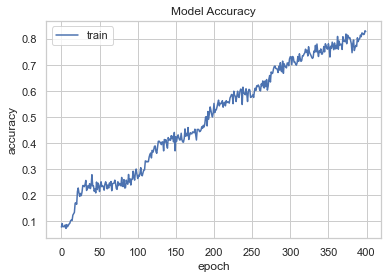

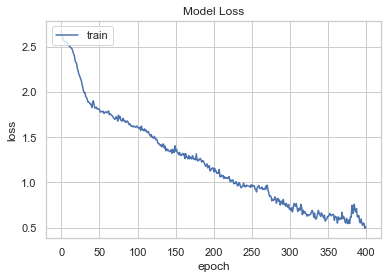

In [17]:
if TEST_MODEL is True:
    ##########################
    # # get model accuracy # #
    ##########################
    plt.plot(history.history['accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

    ######################
    # # get model loss # #
    ######################
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

In [18]:
if TEST_MODEL is True:
    ##########################
    # # view model summary # #
    ##########################
    model.model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 1, 256)            488448    
                                                                 
 dense_25 (Dense)            (None, 1, 256)            65792     
                                                                 
 dropout_20 (Dropout)        (None, 1, 256)            0         
                                                                 
 batch_normalization_15 (Bat  (None, 1, 256)           1024      
 chNormalization)                                                
                                                                 
 lstm_21 (LSTM)              (None, 1, 128)            197120    
                                                                 
 dense_26 (Dense)            (None, 1, 128)            16512     
                                                      

#### MODEL TESTING
- Get Model Accuracy on the Test Dataset
- Generate Confusion Matrix
- Generate ROC Curves
- Save the Model if Appropriate

In [19]:
if TEST_MODEL is True:
    y_pred = model.predict_proba(X_test)

    # evaluate predictions
    acc = accuracy_score(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
    print("Testing accuracy: %.3f%%" % (acc*100))

Testing accuracy: 67.917%


##### Confusion Matrix

240 is the number of test value in kfold_val / train_test_split


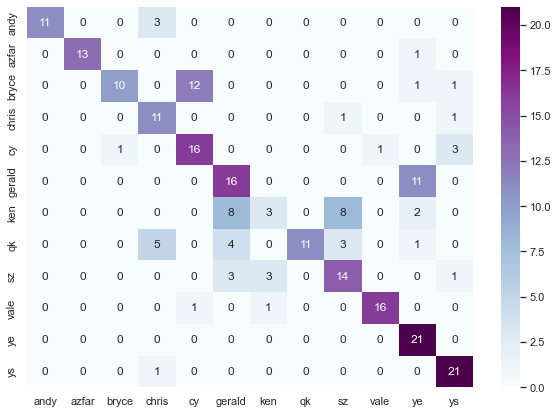

In [20]:
if TEST_MODEL is True and CON_MATRIX is True:
    # confusion matrix
    print(str(len(y_pred)) + " is the number of test value in kfold_val / train_test_split")
    cm = confusion_matrix(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
    df_cm = pd.DataFrame(cm, index = [i for i in np.unique(lb.inverse_transform(y_test))],
                         columns = [i for i in np.unique(lb.inverse_transform(y_test))])

    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, cmap="BuPu")

##### ROC Curve (Individual)

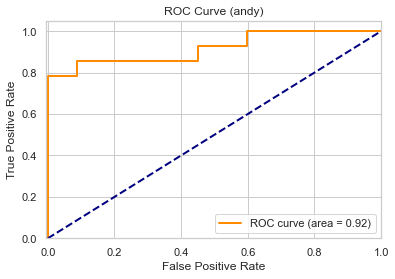

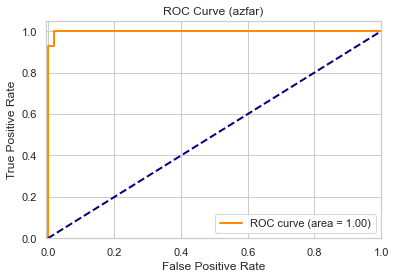

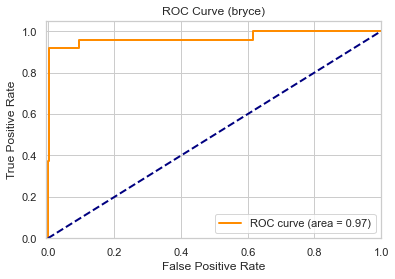

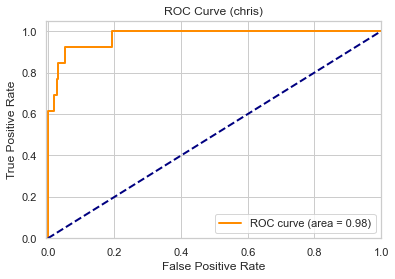

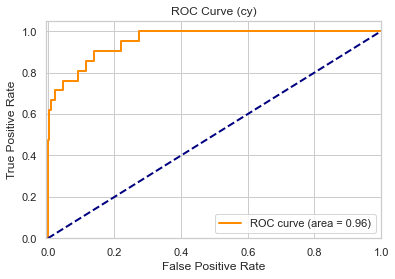

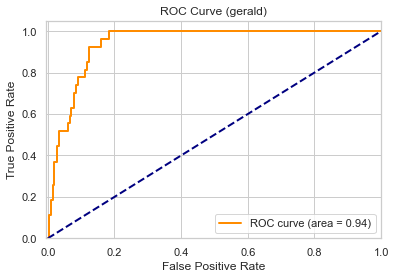

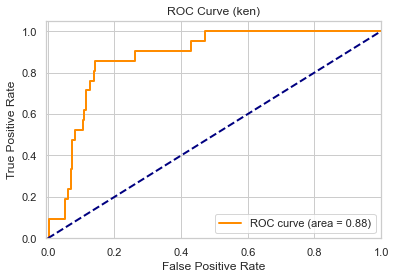

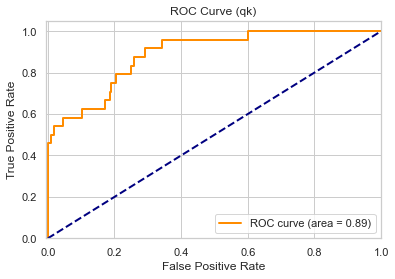

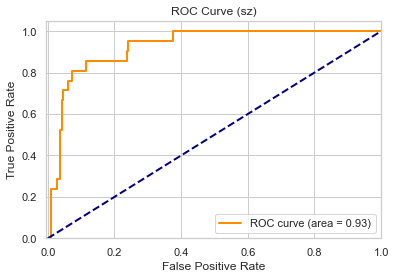

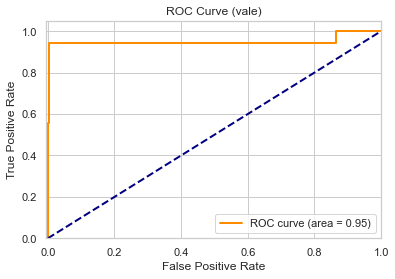

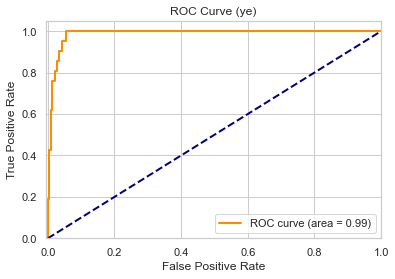

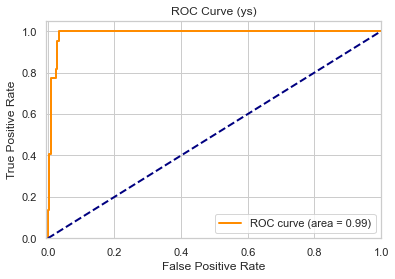

In [21]:
if TEST_MODEL is True and ROC_GRAPH is True: # compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(n_classes):
        plt.figure()
        lw = 2
        plt.plot(
            fpr[i],
            tpr[i],
            color="darkorange",
            lw=lw,
            label="ROC curve (area = %0.2f)" % roc_auc[i],
        )
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        plt.xlim([-0.005, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve (" + str(lb.classes_[i]) + ")")
        plt.legend(loc="lower right")
        plt.show()

##### ROC Curve (Multiclass)

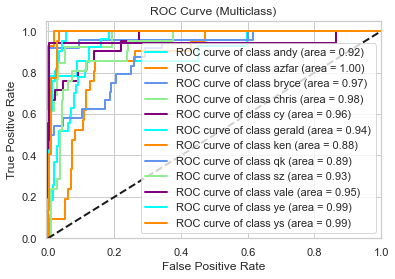

In [22]:
if TEST_MODEL is True and ROC_GRAPH is True:
    # compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], thresholds = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # first aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    # plt.figure()
    # plt.plot(
    #     fpr["micro"],
    #     tpr["micro"],
    #     label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    #     color="deeppink",
    #     linestyle=":",
    #     linewidth=4,
    # )

    # plt.plot(
    #     fpr["macro"],
    #     tpr["macro"],
    #     label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    #     color="navy",
    #     linestyle=":",
    #     linewidth=4,
    # )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "lightgreen", "purple"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(lb.classes_[i], roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([-0.005, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Multiclass)")
    plt.legend(loc="lower right")
    plt.show()

##### ROC Curve (Average)

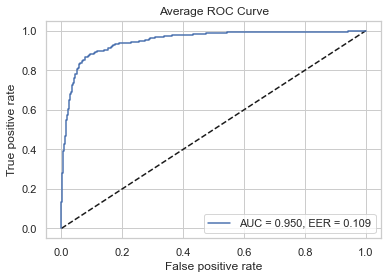

In [23]:
if TEST_MODEL is True and ROC_GRAPH is True:
    fpr, tpr, threshold = roc_curve(y_test.ravel(), y_pred.ravel())

    # calculate equal-error-rate
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='AUC = {:.3f}, EER = {:.3f}'.format(auc(fpr, tpr), eer))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Average ROC Curve')
    plt.legend(loc='best')
    plt.show()

#### FIT AND SAVE MODEL
- Fitting of model
- Get Accuracy and Loss of Mdoel
- Saving Model

In [24]:
############################
# # reshaping of dataset # #
############################
# loading of dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)

df.head()
dataset = df.values

# divide data into features X and target (classes) Y
# convert target Y to labelbinarizer Y for model
X, Y, lb, class_list = prepare_dataset(df)

# reshaping the dataset to include LSTM Timesteps
X = reshape_dataset(X, TIMESTEPS)
n_classes = Y.shape[1]

#####################
# # fit the model # #
#####################

model = create_model()
es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                   verbose=0)
history = model.fit(X, Y, callbacks=es)

LabelBinarizer is able to decipher: 
['andy' 'azfar' 'bryce' 'chris' 'cy' 'gerald' 'ken' 'qk' 'sz' 'vale' 'ye'
 'ys']


X | Features | Dataset Shape: (1200, 220)
Y | Classes  | Dataset Shape: (1200, 12)
There are a total of 12 classes.
Epoch 1/400
6/6 [==============================] - 5s 19ms/step - loss: 2.6239 - accuracy: 0.0767
Epoch 2/400
6/6 [==============================] - 0s 16ms/step - loss: 2.5921 - accuracy: 0.0817
Epoch 3/400
6/6 [==============================] - 0s 25ms/step - loss: 2.5680 - accuracy: 0.0867
Epoch 4/400
6/6 [==============================] - 0s 18ms/step - loss: 2.5534 - accuracy: 0.0908
Epoch 5/400
6/6 [==============================] - 0s 19ms/step - loss: 2.5272 - accuracy: 0.0925
Epoch 6/400
6/6 [==============================] - 0s 19ms/step - loss: 2.5350 - accuracy: 0.0775
Epoch 7/400
6/6 [==============================] - 0s 21ms/step - loss: 2.5246 - accuracy: 0.0950
Epoch 8/400
6/6 [==============================] - 0s 19ms/step - loss: 2.5269

6/6 [==============================] - 0s 19ms/step - loss: 0.7737 - accuracy: 0.7933
Epoch 164/400
6/6 [==============================] - 0s 19ms/step - loss: 0.7455 - accuracy: 0.7900
Epoch 165/400
6/6 [==============================] - 0s 19ms/step - loss: 0.7557 - accuracy: 0.7850
Epoch 166/400
6/6 [==============================] - 0s 26ms/step - loss: 0.7380 - accuracy: 0.7942
Epoch 167/400
6/6 [==============================] - 0s 20ms/step - loss: 0.7693 - accuracy: 0.7950
Epoch 168/400
6/6 [==============================] - 0s 20ms/step - loss: 0.7524 - accuracy: 0.7958
Epoch 169/400
6/6 [==============================] - 0s 20ms/step - loss: 0.7185 - accuracy: 0.8100
Epoch 170/400
6/6 [==============================] - 0s 19ms/step - loss: 0.7098 - accuracy: 0.8083
Epoch 171/400
6/6 [==============================] - 0s 21ms/step - loss: 0.7002 - accuracy: 0.8117
Epoch 172/400
6/6 [==============================] - 0s 20ms/step - loss: 0.7223 - accuracy: 0.7942
Epoch 173/400


6/6 [==============================] - 0s 19ms/step - loss: 0.4873 - accuracy: 0.8583
Epoch 246/400
6/6 [==============================] - 0s 19ms/step - loss: 0.4914 - accuracy: 0.8608
Epoch 247/400
6/6 [==============================] - 0s 19ms/step - loss: 0.4612 - accuracy: 0.8650
Epoch 248/400
6/6 [==============================] - 0s 19ms/step - loss: 0.4656 - accuracy: 0.8708
Epoch 249/400
6/6 [==============================] - 0s 19ms/step - loss: 0.5091 - accuracy: 0.8517
Epoch 250/400
6/6 [==============================] - 0s 19ms/step - loss: 0.5421 - accuracy: 0.8442
Epoch 251/400
6/6 [==============================] - 0s 19ms/step - loss: 0.4795 - accuracy: 0.8617
Epoch 252/400
6/6 [==============================] - 0s 20ms/step - loss: 0.4681 - accuracy: 0.8675
Epoch 253/400
6/6 [==============================] - 0s 19ms/step - loss: 0.4569 - accuracy: 0.8700
Epoch 254/400
6/6 [==============================] - 0s 19ms/step - loss: 0.4316 - accuracy: 0.8800
Epoch 255/400


6/6 [==============================] - 0s 19ms/step - loss: 0.3325 - accuracy: 0.9083
Epoch 328/400
6/6 [==============================] - 0s 20ms/step - loss: 0.3521 - accuracy: 0.8925
Epoch 329/400
6/6 [==============================] - 0s 19ms/step - loss: 0.3293 - accuracy: 0.9042
Epoch 330/400
6/6 [==============================] - 0s 19ms/step - loss: 0.3064 - accuracy: 0.9150
Epoch 331/400
6/6 [==============================] - 0s 20ms/step - loss: 0.3086 - accuracy: 0.9117
Epoch 332/400
6/6 [==============================] - 0s 20ms/step - loss: 0.3256 - accuracy: 0.9108
Epoch 333/400
6/6 [==============================] - 0s 19ms/step - loss: 0.3092 - accuracy: 0.9167
Epoch 334/400
6/6 [==============================] - 0s 20ms/step - loss: 0.3181 - accuracy: 0.9183
Epoch 335/400
6/6 [==============================] - 0s 20ms/step - loss: 0.3049 - accuracy: 0.9167
Epoch 336/400
6/6 [==============================] - 0s 19ms/step - loss: 0.3612 - accuracy: 0.9042
Epoch 337/400


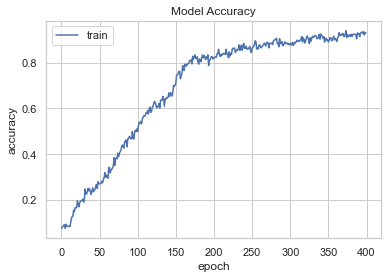

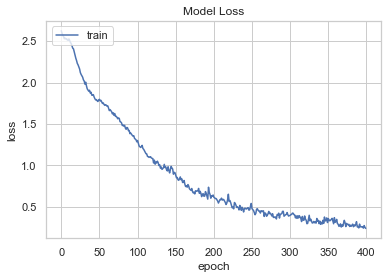

In [25]:
##########################
# # get model accuracy # #
##########################
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

######################
# # get model loss # #
######################
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

#### SAVE MODEL

In [26]:
##################
# # save model # #
##################
model.model.save(MODEL_PATH)

# LIVE TESTING
> Live test with new dataset to check if model function as it should

#### LOAD MODEL

In [27]:
##################
# # load model # #
##################

# model = create_model()
model = load_model(MODEL_PATH)

#### LOAD DATA
- Import new dataset to verify the model is able to predict accurately

In [28]:
# import unseen data
pred_df = pd.read_csv(ACTUAL_DATASET_PATH)
pred_df.head()

,Subject,Password,T2-D|0,T2-I|0+1,T2-PF|0+1,T2-RF|0+1,T2-NG|0+1,T2-D|1,T2-I|1+2,T2-PF|1+2,...,T7-RF|VAR,T7-NG|VAR,T7-I|SD,T7-PF|SD,T7-RF|SD,T7-NG|SD,T8-I|0+7,T8-PF|0+7,T8-RF|0+7,T8-NG|0+7
0,andy,dEcisi0n,0.112628,0.079001,0.191629,0.189652,0.302280,0.110651,0.057247,0.167898,...,0.009187,0.009457,0.062313,0.063711,0.095848,0.097245,1.136681,1.249309,1.201873,1.314501
1,andy,dEcisi0n,0.102941,0.191321,0.294262,0.280651,0.383592,0.089330,0.089771,0.179101,...,0.022846,0.025848,0.118682,0.128306,0.151149,0.160773,0.989301,1.092242,1.067423,1.170363
2,andy,dEcisi0n,0.114735,0.099664,0.214399,0.212517,0.327251,0.112853,0.101198,0.214051,...,0.016034,0.016373,0.071080,0.072410,0.126627,0.127957,0.888561,1.003296,0.967641,1.082376
3,andy,dEcisi0n,0.113787,0.089431,0.203218,0.178590,0.292377,0.089159,0.057329,0.146488,...,0.006316,0.009388,0.038356,0.055770,0.079475,0.096889,0.832373,0.946160,0.887580,1.001367
4,andy,dEcisi0n,0.121229,0.147608,0.268837,0.248161,0.369389,0.100553,0.068432,0.168985,...,0.018494,0.022685,0.102827,0.117447,0.135994,0.150615,0.879454,1.000683,0.958523,1.079751


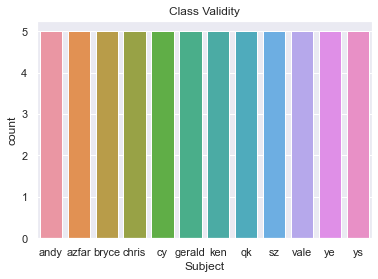

In [29]:
################################
# # check for class validity # #
################################
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Subject", data=pred_df).set_title("Class Validity")

# remove missing values if available
pred_df = pred_df.dropna()

In [30]:
pred_dataset = pred_df.values
actual_np = pred_dataset[:,CLASSES_COL_NUM]

# # divide data into features X
# pred_row = pred_dataset[:,3:].astype(float)

########################
# # predict all rows # #
########################
pred_row=pred_df.iloc[:,FEATURES_COL_NUM:]

#################################
# # predict more than one row # #
#################################

# pred_row=pred_df.iloc[46:54,FEATURES_COL_NUM:]
# print(pred_row)

############################
# # predict a single row # #
############################

# pred_row=pred_df.iloc[11:12,FEATURES_COL_NUM:]

##################
# # shape data # #
##################
pred_row = pred_row.values.tolist()
pred_arr = np.asarray(pred_row, dtype=np.float32)
pred_arr = np.reshape(pred_arr, (pred_arr.shape[0], TIMESTEPS, pred_arr.shape[1]))

print(class_list)
Y = np.asarray(class_list)
Y = Y.reshape(-1, 1)
lb = LabelBinarizer().fit(Y)
Y = lb.transform(Y)

['andy', 'azfar', 'bryce', 'chris', 'cy', 'gerald', 'ken', 'qk', 'sz', 'vale', 'ye', 'ys']


In [31]:
####################################
# # get prediction and its label # #
####################################

pred_proba = model.predict(pred_arr)

# pred_proba = np.sum(pred_proba, axis=0)
# pred_proba = np.reshape(pred_proba, (1, 9))

pred = lb.inverse_transform(pred_proba)
acc = np.max(pred_proba, axis=1)

match_list = []

for _ in range(actual_np.size):
    if pred[_] == actual_np[_]:
        match_list.append("match")
    else:
        match_list.append("nope")

match_count = match_list.count("match")
total_count = len(match_list)

match_header = str(match_count) + "/" + str(total_count) + " (" + str(match_count/total_count*100)+ "%)"
match_np = np.array(match_list)

exported_output = np.column_stack((actual_np, pred))
exported_output = np.column_stack((exported_output, acc))
exported_output = np.column_stack((exported_output, match_np))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.DataFrame(data=exported_output, index=None, columns=['Actual', 'Prediction', 'Accuracy', match_header])
# print(df)
df.to_csv(RESULT_PATH)

print("Accuracy of the Model is: " + str(match_header))

Accuracy of the Model is: 54/60 (90.0%)


In [32]:
# print elapsed time
elapsed_time = time.time() - start_time
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 00:28:47
